In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from keras import layers
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
import cv2
from keras.models import Model
from keras.layers import Input

# first, mount the drive
from google.colab import drive
drive.mount('/content/drive')
# second, access the data
data = pd.read_csv('/content/drive/MyDrive/Data/face_data.csv')

Mounted at /content/drive


# Helper Functions:
### convert data to numpy arrays, display an image, reindex the data frame, view proportion numbers of a categorical variable

In [2]:
# Function that converts a image of pixels (represented as a string) to an array; Where img is a string of pixel values
def arr_convert(img):
  return np.array(img.split()).astype('float64')

# Function for converting data as a whole to arrays; Where data is a container data structure (e.g. Series)
def arr_conversion(data):
  l1 = []
  for i in data:
    l1.append(arr_convert(i))
  return np.array(l1)

# Display image assuming it was not already converted to array; Where img is a string of pixel values
def display_pre(img):
    plt.imshow(arr_convert(img).reshape(48,48), cmap='gray')
    plt.axis('off')
    plt.show()
# Display image assuming it was already converted to ndarray; Where img is a array of pixel values
def display_post(img):
    plt.imshow(img.reshape(48,48), cmap='gray')
    plt.axis('off')
    plt.show()

# Function that reindex the Data Frame; Where DF is a data frame
def reindexDF(DF):
  return (DF.reset_index().drop(columns = ['index']))

# Function that looks at number of occurrences of a category in catgeorical variable; Where S is a Series
def cat_num(S):
  return S.value_counts()
# Function for checking percentages specifically
def checkperc(S):
  return round(((S.value_counts()/S.value_counts().sum())*100), 2)

# Data Wrangling
### clean, transform, reduce the data (only for random duplicates), format the data properly, address data quality issues (e.g. class imbalance), One Hot Encode

In [3]:
# Make a copy of the data frame
face_data = data.copy()

# Fix minor issue with column names and remove irrelevant variable ' Usage'
face_data = (face_data.drop([' Usage'], axis=1)).rename(columns = {' emotion': 'emotion', ' pixels': 'pixels'})

# 0 = Angry, 3 = Happy, 4 = Sad, 6 = Neutral;
# Remove irrelavent labels: 1 = Disgust, 2 = Fear, 5 = Surprise
face_data = face_data[face_data['emotion'].isin([0, 3, 4, 6])]

# Check if there are missing observations
face_data.isnull().count()

# Check if there are random duplicates; Yes there are 686 random duplicates
face_data.duplicated().sum()
# Remove those duplicates
face_data = face_data.drop_duplicates()

# Check if there are missing pixels in images; If there is an image with missing pixel, an error will be thrown; Should take around 25-30 seconds
def PixelCheck(images):
  for image in images:
    np.array(image.split()).astype('int64').reshape(48,48)
# Check for missing pixels
PixelCheck(face_data['pixels'])

In [4]:
# 0 = Angry, 3 = Happy, 4 = Sad, 6 = Neutral;
# Check percentages for emotions
checkperc(face_data['emotion'])

3    34.47
6    23.72
4    23.24
0    18.57
Name: emotion, dtype: float64

In [5]:
# Check number of observations per emotion
cat_num(face_data['emotion'])

3    8800
6    6057
4    5934
0    4740
Name: emotion, dtype: int64

In [6]:
from imblearn.over_sampling import RandomOverSampler
#  Lets Oversample for the minority classes so that we address the class imbalance issue
oversampler = RandomOverSampler(sampling_strategy='auto') # make sure all classes are uniform (i.e. same number of instances)
X_over, Y_over = oversampler.fit_resample(face_data['pixels'].values.reshape(-1,1), face_data['emotion'])
X_over_series = pd.Series(X_over.flatten())

# Check that we have uniformity
(pd.DataFrame({'emotion': Y_over, 'images': X_over_series}))['emotion'].value_counts()

0    8800
4    8800
6    8800
3    8800
Name: emotion, dtype: int64

In [7]:
# split into train, valid, and test sets
from sklearn.model_selection import train_test_split

# Feature
X = np.array(X_over_series)
# Label
y = np.array(Y_over)

# Split into train and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=0)

In [8]:
# Make sure all images are arrays
X_train = arr_conversion(X_train)
X_val = arr_conversion(X_val)
X_test = arr_conversion(X_test)

# Normalize the training data
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

# Reshape so that the data can actually fit into the model
X_train = X_train.reshape(-1, 48,48,1)
X_val = X_val.reshape(-1,48,48,1)
X_test = X_test.reshape(-1, 48,48, 1)

In [9]:
### One Hot Encode our labels
from sklearn.preprocessing import OneHotEncoder
# 0 = Angry, 3 = Happy, 4 = Sad, 6 =Neutral
#dict = {[0,'Angry']:0, [3,'Happy']:1, [4,'Sad']:2, [6,'Neutral']:3}

# function for one hot encoding the label
def ONE_HOT_ENCODE(label_data):
  y_train_TEST = tuple(label_data)
  TEST_DF = pd.DataFrame(y_train_TEST, columns=['emotions'])
  TEST_DF['emotions'] = TEST_DF['emotions'].astype('category')
  TEST_DF['emotions_CAT'] = TEST_DF['emotions'].cat.codes
  enc = OneHotEncoder(handle_unknown='ignore')
  enc_df = pd.DataFrame(enc.fit_transform(TEST_DF[['emotions_CAT']]).toarray())
  TEST_DF = TEST_DF.join(enc_df)
  TEST_DF = TEST_DF.drop(columns=['emotions', 'emotions_CAT'])
  return TEST_DF.to_numpy()

# one hot encoding the training and validation labels
y_train = ONE_HOT_ENCODE(y_train)
y_val = ONE_HOT_ENCODE(y_val)
y_test = ONE_HOT_ENCODE(y_test)

# Model Building
### Building a Convolution Neural Network (CNN) with 5 convolutional layers, uses Max Pooling, with Rectified Linear Unit (ReLU) activation functions per layer, 3x3 kernal, stride of 1, regularized with drop out of 60%, batch normalization for consistency, and early stopping. Also has the output layer activation of softmax that produces vector of probabilities.
### Uses Adam to optimize the loss function Categorical Cross Entropy with a 0.01% learning rate

In [10]:
from keras.optimizers.legacy.adam import Adam
from keras.layers import Conv2D, MaxPool2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def emotion_recognition(input_shape):
  # input layer
  X_input = Input(input_shape)
  # 1st conv layer
  X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # 2nd conv layer
  X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  # 3rd conv layer
  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  # 4th conv layer
  X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  # 5th conv layer
  X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)

  # dense layer
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.6)(X)
  X = Dense(4, activation = 'softmax')(X)

  # instantiate the model
  model = Model(inputs=X_input, outputs=X)
  return model

# Compile the model
model = emotion_recognition((48,48,1))
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/30
891/891 [==============================] - 26s 12ms/step - loss: 1.3534 - accuracy: 0.3642 - val_loss: 1.1932 - val_accuracy: 0.4760
Epoch 2/30
891/891 [==============================] - 10s 12ms/step - loss: 1.1720 - accuracy: 0.4674 - val_loss: 1.0561 - val_accuracy: 0.5464
Epoch 3/30
891/891 [==============================] - 10s 12ms/step - loss: 1.0706 - accuracy: 0.5294 - val_loss: 0.9776 - val_accuracy: 0.5767
Epoch 4/30
891/891 [==============================] - 10s 12ms/step - loss: 0.9924 - accuracy: 0.5712 - val_loss: 0.9728 - val_accuracy: 0.5830
Epoch 5/30
891/891 [==============================] - 11s 13ms/step - loss: 0.9298 - accuracy: 0.6028 - val_loss: 0.8843 - val_accuracy: 0.6326
Epoch 6/30
891/891 [==============================] - 10s 12ms/step - loss: 0.8686 - accuracy: 0.6392 - val_loss: 0.8328 - val_accuracy: 0.6562
Epoch 7/30
891/891 [==============================] - 10s 12ms/step - loss: 0.8069 - accuracy: 0.6672 - val_loss: 0.8321 - val_accuracy:

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

110/110 [==============================] - 1s 5ms/step - loss: 0.7145 - accuracy: 0.7574
Test Loss: 0.7145275473594666
Test Accuracy: 0.7573863863945007


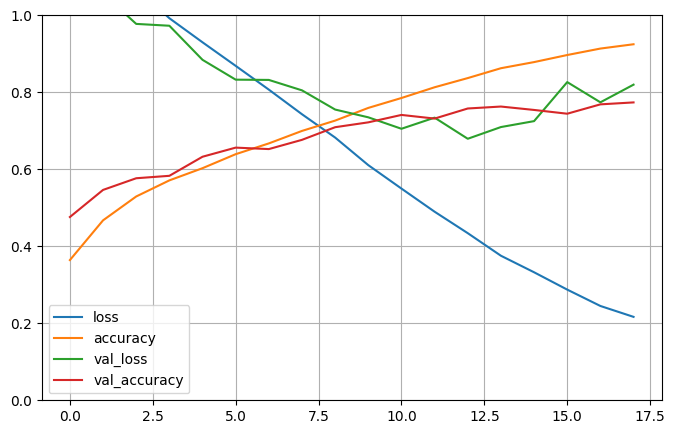

In [12]:
# Visualize learning curve
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [13]:
# Save model architecture
model_json = model.to_json()
with open('model_architecture2.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights('model_weights2.h5')